In [1]:
!pip install torch
!pip install torchvision

In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split,RandomizedSearchCV
import matplotlib.pyplot as plt

In [9]:
>>> from sklearn.ensemble import RandomForestClassifier
>>> from sklearn.ensemble import ExtraTreesClassifier
>>> from sklearn.tree import DecisionTreeClassifier

In [2]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)),
                             ])

In [3]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)//5
batch_size_test=len(test_set)

In [4]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [5]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

### Random forest

В Random forest всяко дърво в ансамбъла се изгражда от извадка, изтеглена чрез замяна от данните за обучение. Също така при разделянето на възлите по време на изграждането на дървото, най-доброто разделяне се намира или от всички входни характеристики, или от произволно подмножество от размер max_features.

### Extra trees

В Extra trees, случайността отива една стъпка напред в начина, по който се изчисляват разделянията. Както в Random forest, се използва произволно подмножество от кандидат-характеристики, но вместо да се търсят най-дискриминиращите прагове, те се чертаят на случаен принцип за всяка кандидат-характеристика и най-добрият от тези произволно генерирани прагове се избира като правило за разделяне. Това обикновено позволява да се намали дисперсията на модела малко повече, за сметка на малко по-голямо увеличение на отклонението.

### Comparing the models

Ще направим крос валидация на четирите модела и ще ги сравним.

In [13]:
model_lbls = [
              'DecisionTree', 'RandomForest', 'ExtraTrees', 
            ]

models = {
    'DecisionTree': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(), 
           'param': [{}],
          },
    'RandomForest': {'name': 'Random Forest',
           'estimator': RandomForestClassifier(),
           'param': [{}]
          },
    'ExtraTrees': {'name': 'Extra Trees',
           'estimator': ExtraTreesClassifier(),
           'param': [{}],
          },
}

scores = ['precision', 'recall','f1']

In [18]:
def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    true_y, pred_y = test_y, model.predict(test_x)
    print(classification_report(true_y, pred_y))
    print()

In [ ]:

def evaluate_models(models):
    results_short = {}
    for score in scores:
        print('='*40)
        print("# Tuning hyper-parameters for %s" % score)
        print()

        for m in model_lbls:
            print('-'*40)
            print("Trying model {}".format(models[m]['name']))
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s_macro' % score, 
                               return_train_score = False,
                               n_jobs = 2, 
                               )
            clf.fit(train_x, train_y)
            print_results(clf)
            results_short[m] = clf.best_score_
        print("Summary of results for {}".format(score))
        print("Estimator")
        for m in results_short.keys():
            print("{}\t - score: {:4.2}%".format(models[m]['name'], results_short[m]))

In [14]:
evaluate_models(models)

# Tuning hyper-parameters for precision

----------------------------------------
Trying model Decision Tree
Best parameters set found on train set:

{}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1000
           1       0.94      0.92      0.93      1000
           2       0.60      0.63      0.62      1000
           3       0.79      0.77      0.78      1000
           4       0.64      0.63      0.63      1000
           5       0.87      0.86      0.86      1000
           6       0.50      0.50      0.50      1000
           7       0.85      0.86      0.86      1000
           8       0.87      0.86      0.87      1000
           9       0.88      0.89      0.89      1000

    accuracy                           0.76     10000
   macro avg     

Best parameters set found on train set:

{}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1000
           1       0.99      0.95      0.97      1000
           2       0.72      0.78      0.75      1000
           3       0.85      0.89      0.87      1000
           4       0.74      0.79      0.76      1000
           5       0.96      0.93      0.95      1000
           6       0.69      0.55      0.61      1000
           7       0.91      0.94      0.92      1000
           8       0.94      0.96      0.95      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.86      0.85     10000


Summary of resul

Decision tree дава сравнитело по-лош резултат от Random forest и Extra trees, за това ще го оставим за сега, но може би с правилните параметри ще ги надмине.

In [20]:
model_lbls = [
             'RandomForest', 'ExtraTrees', 
            ]

models = {
    'RandomForest': {'name': 'Random Forest',
           'estimator': RandomForestClassifier(),
           'param': [{
               'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
           }]
          },
    'ExtraTrees': {'name': 'Extra Trees',
           'estimator': ExtraTreesClassifier(),
           'param': [{
               'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
           }],
          },
}

scores = ['f1']

In [16]:

def evaluate_models_random(models):
    results_short = {}
    for score in scores:
        print('='*40)
        print("# Tuning hyper-parameters for %s" % score)
        print()

        for m in model_lbls:
            print('-'*40)
            print("Trying model {}".format(models[m]['name']))
            clf = RandomizedSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s_macro' % score, 
                                n_iter=50,
                               return_train_score = False,
                               n_jobs = -1, 
                               )
            clf.fit(train_x, train_y)
            print_results(clf)
            results_short[m] = clf.best_score_
        print("Summary of results for {}".format(score))
        print("Estimator")
        for m in results_short.keys():
            print("{}\t - score: {:4.2}%".format(models[m]['name'], results_short[m]))

Поради това че алгоритмите имат прекалено много параметри ще използваме RandomizedSearchCV и ще разгледаме само 50 възможни комбинации от праметри от възможните 4000+. По този начин няма да можем да изведем близък отговор, но може да видим дали има зависимости между параметрите.

In [21]:
evaluate_models_random(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Random Forest
Best parameters set found on train set:

{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.99      0.93      0.96      1000
           2       0.68      0.77      0.72      1000
           3       0.82      0.89      0.85      1000
           4       0.70      0.79      0.74      1000
           5       0.98      0.93      0.95      1000
           6       0.71      0.47      0.56      1000
           7       0.90      0.92      0.91      1000
           8       0.94      0.96      0.95      1000
      

In [22]:
evaluate_models_random(models)

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Random Forest
Best parameters set found on train set:

{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.99      0.93      0.96      1000
           2       0.67      0.76      0.71      1000
           3       0.81      0.89      0.85      1000
           4       0.69      0.79      0.74      1000
           5       0.97      0.93      0.95      1000
           6       0.70      0.46      0.55      1000
           7       0.89      0.91      0.90      1000
           8       0.94      0.96      0.95      1000
     

Забелязва се че няма зависимост между параметрите или поне не голяма, а разликата в оценката най-вероятно се дължи на на случайността в алгоритмите.

**n_estimators:** броят на дърветата в гората.

**max_depth:** максималната дълбочина на дървото.

**min_samples_split:** минималният брой от проби, нужни за разделяне възел.

**min_samples_leaf:** минималният брой от проби, нужни за да бъде листо. Една точка за разделяне ще бъде взета предвид само ако оставя поне

**min_samples** тренировъчни данни в левия и десния клон.

**max_features:** броят от характеристиките за обмисляне когато се търси за най-доброто разцепване.

**bootstrap:** дали се ползват всички данни за построяването на дървото или части от тях.

In [8]:
def plot_scores_by_parameter(model,ks,X_train,X_test,y_train,y_test,visualize=True):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = model(k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(ks, train_scores, color='blue', label='train score')
        plt.plot(ks, test_scores, color='green', label='test score')
        plt.legend()
    return train_scores,test_scores

In [9]:
def bar_plot_scores_by_parameter(model,ks,X_train,X_test,y_train,y_test,visualize=True):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = model(k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.bar(ks, train_scores, color='blue', label='train score')
        plt.bar(ks, test_scores, color='green', label='test score')
        plt.legend()
    return train_scores,test_scores

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, random_state=0)

In [25]:
X_valid.shape

torch.Size([3000, 784])

In [31]:
rndm_constructor = lambda a: RandomForestClassifier(bootstrap = a)

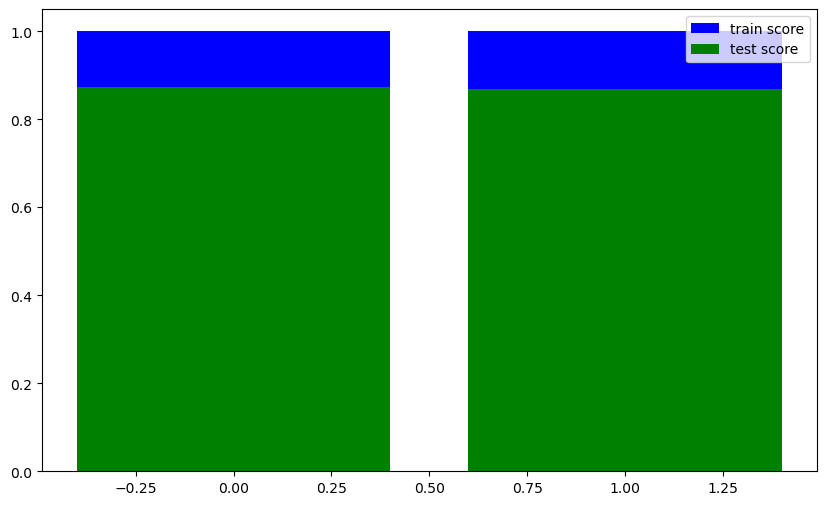

In [32]:
_=bar_plot_scores_by_parameter(rndm_constructor,[True,False],X_train,X_valid,y_train,y_valid)

In [1]:
rndm_constructor = lambda a: RandomForestClassifier(max_depth = a)

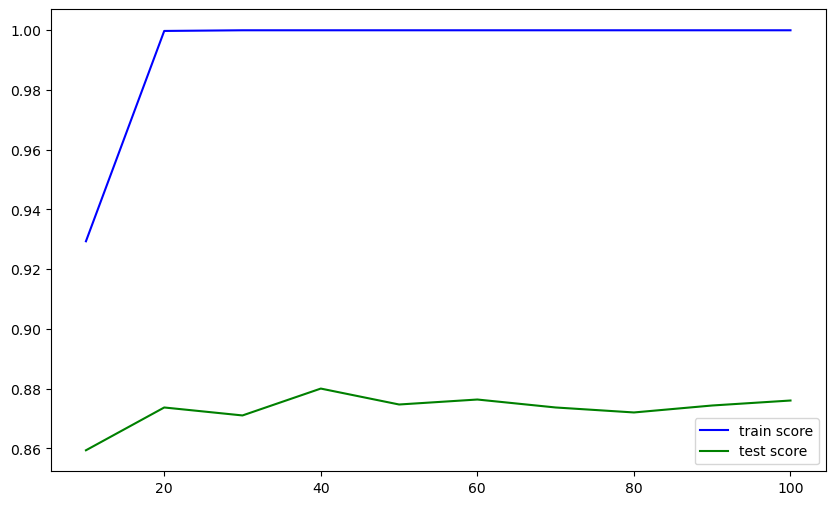

In [15]:
_=plot_scores_by_parameter(rndm_constructor,[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],X_train,X_valid,y_train,y_valid)

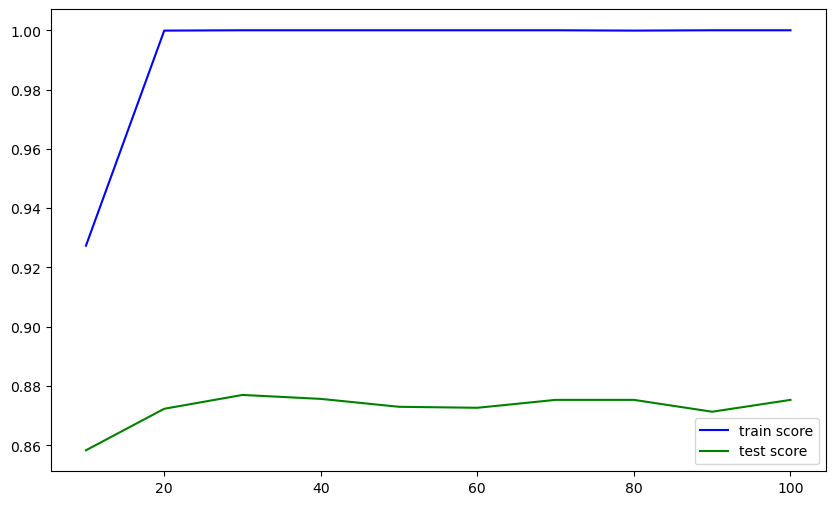

In [16]:
_=plot_scores_by_parameter(rndm_constructor,[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],X_train,X_valid,y_train,y_valid)

In [33]:
rndm_constructor = lambda a: RandomForestClassifier(max_features = a)

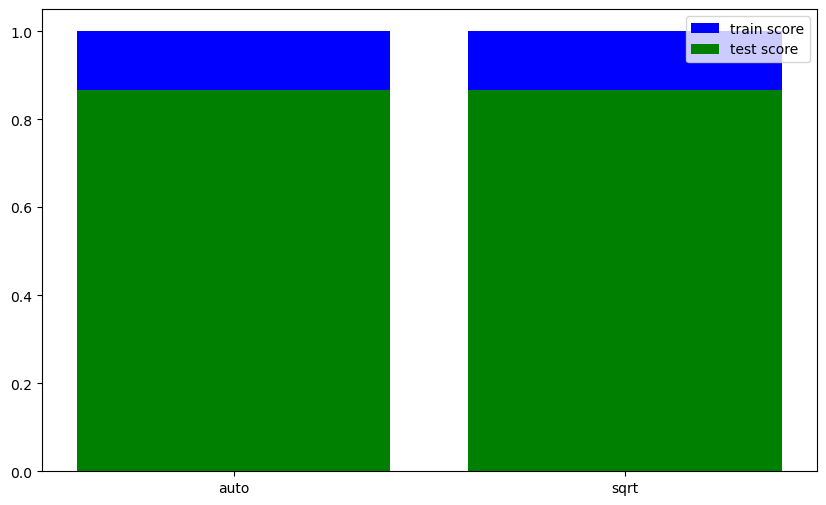

In [37]:
_=bar_plot_scores_by_parameter(rndm_constructor,['auto', 'sqrt'],X_train,X_valid,y_train,y_valid)

In [38]:
rndm_constructor = lambda a: RandomForestClassifier(min_samples_leaf = a)

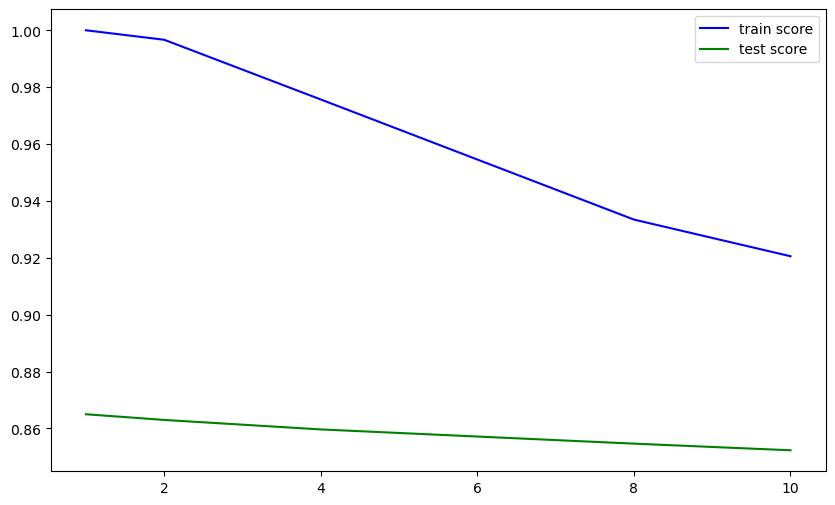

In [40]:
_=plot_scores_by_parameter(rndm_constructor,[1,2,4,8,10],X_train,X_valid,y_train,y_valid)

In [42]:
rndm_constructor = lambda a: RandomForestClassifier(min_samples_split = a)

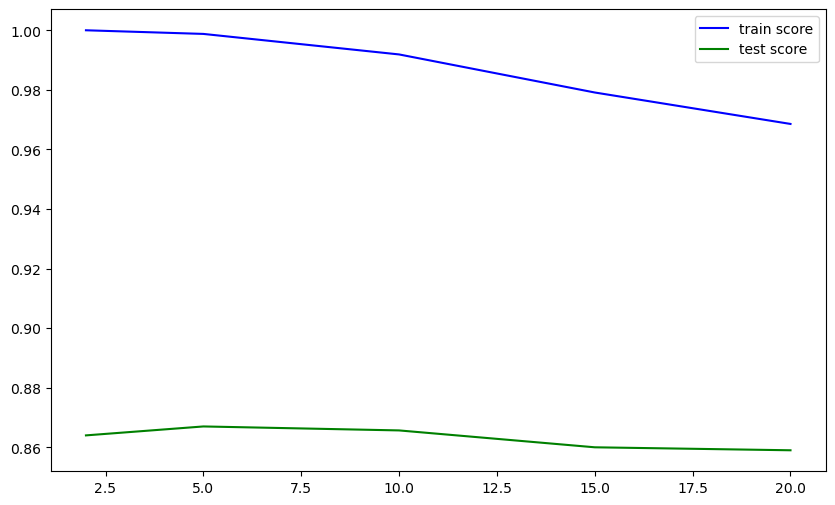

In [43]:
_=plot_scores_by_parameter(rndm_constructor,[2,5,10,15,20],X_train,X_valid,y_train,y_valid)

In [44]:
rndm_constructor = lambda a: RandomForestClassifier(n_estimators = a)

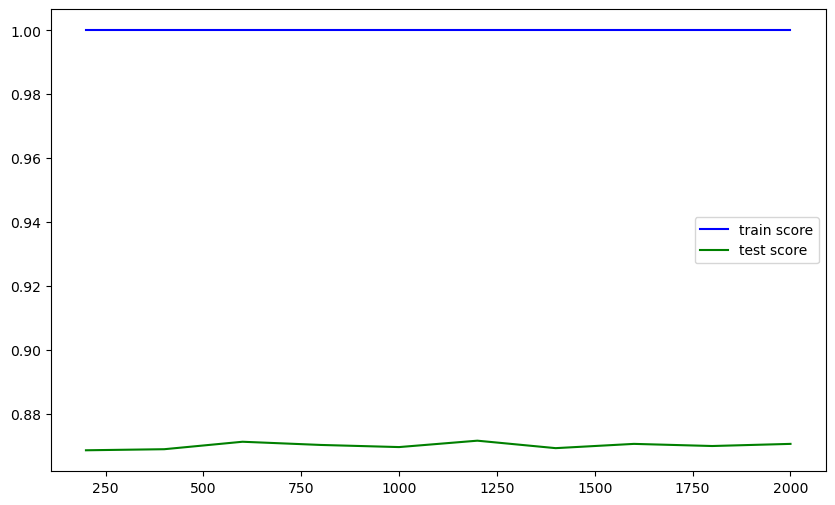

In [45]:
_=plot_scores_by_parameter(rndm_constructor,[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],X_train,X_valid,y_train,y_valid)

Параметрите в случая играят малка роля в подобряването на алгоритъма. Резултатът варира поради случайността в алгоритъма, а не при промяна на праметрите.

### Extra Trees

In [17]:
extra_constructor = lambda a: ExtraTreesClassifier(bootstrap = a)

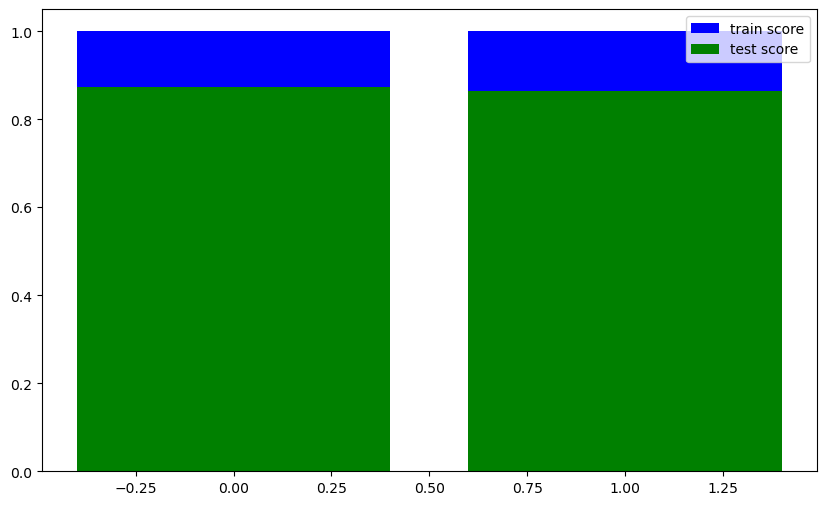

In [19]:
_=bar_plot_scores_by_parameter(extra_constructor,[True,False],X_train,X_valid,y_train,y_valid)

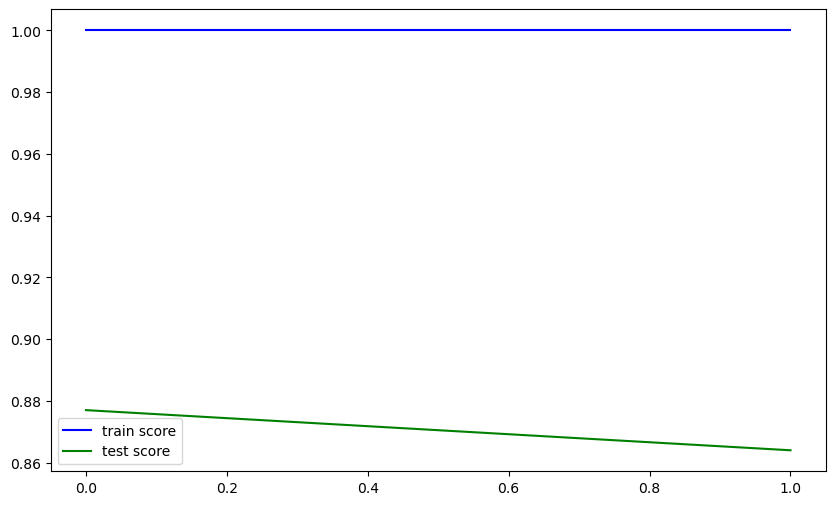

In [20]:
_=plot_scores_by_parameter(extra_constructor,[True,False],X_train,X_valid,y_train,y_valid)

In [21]:
extra_constructor = lambda a: ExtraTreesClassifier(max_depth = a)

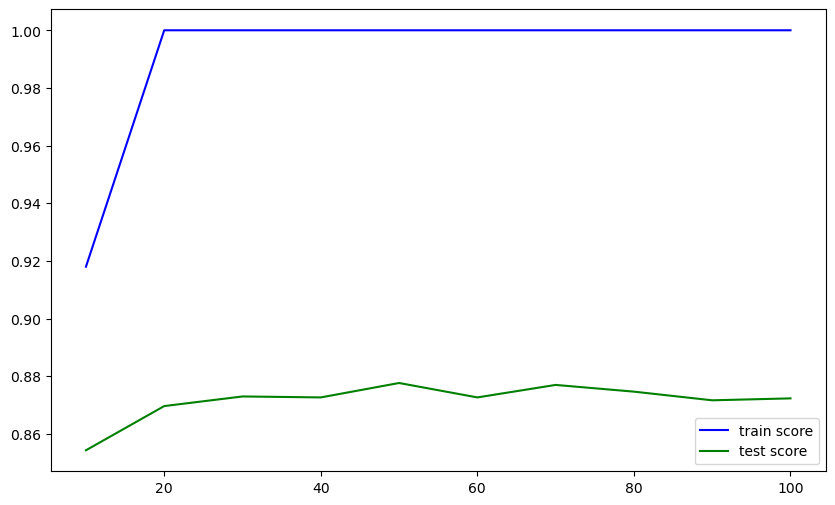

In [22]:
_=plot_scores_by_parameter(extra_constructor,[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],X_train,X_valid,y_train,y_valid)

In [37]:
extra_constructor = lambda a: ExtraTreesClassifier(max_depth = a, bootstrap = True)

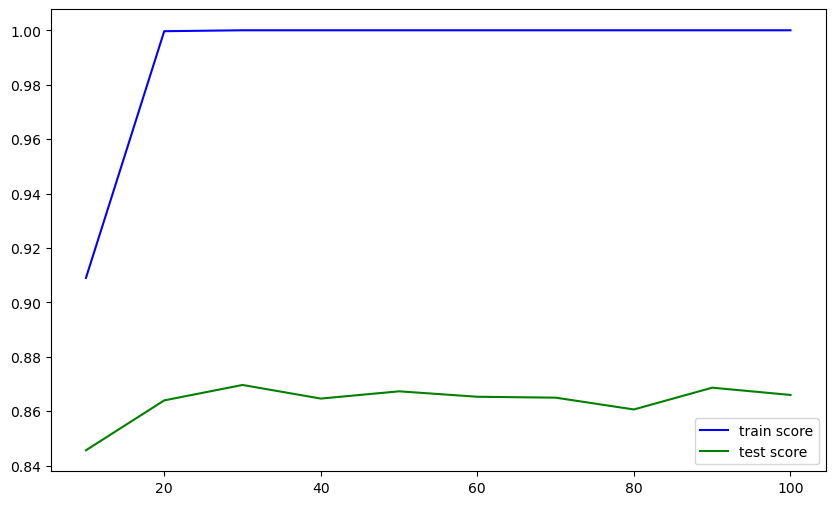

In [38]:
_=plot_scores_by_parameter(extra_constructor,[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],X_train,X_valid,y_train,y_valid)

In [24]:
extra_constructor = lambda a: ExtraTreesClassifier(max_features = a) 

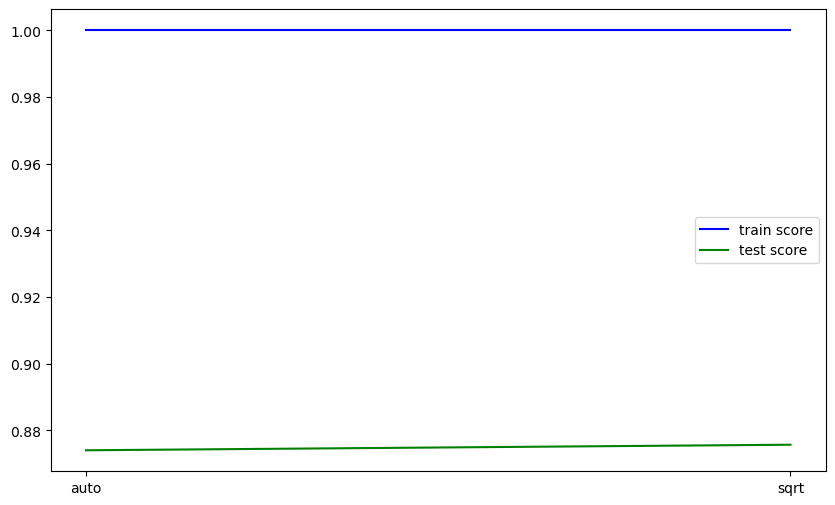

In [25]:
_=plot_scores_by_parameter(extra_constructor,['auto', 'sqrt'],X_train,X_valid,y_train,y_valid)

In [26]:
extra_constructor = lambda a: ExtraTreesClassifier(min_samples_leaf = a) 

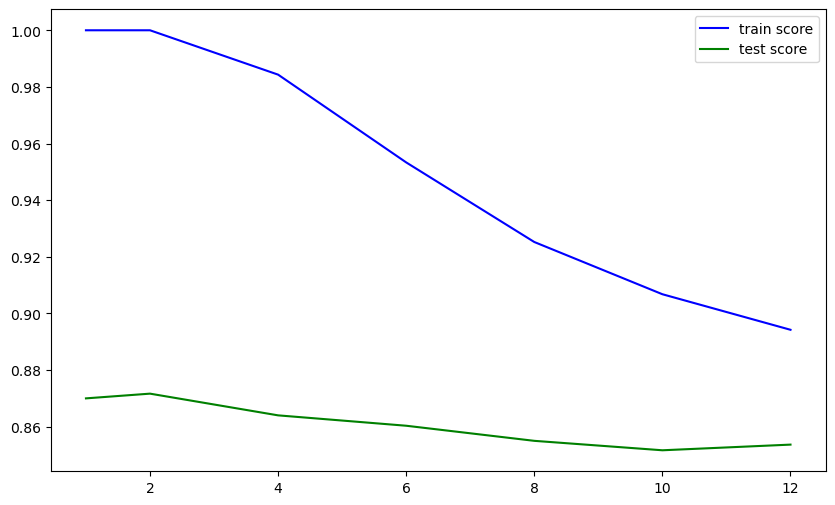

In [27]:
_=plot_scores_by_parameter(extra_constructor,[1,2,4,6,8,10,12],X_train,X_valid,y_train,y_valid)

In [28]:
extra_constructor = lambda a: ExtraTreesClassifier(min_samples_split = a) 

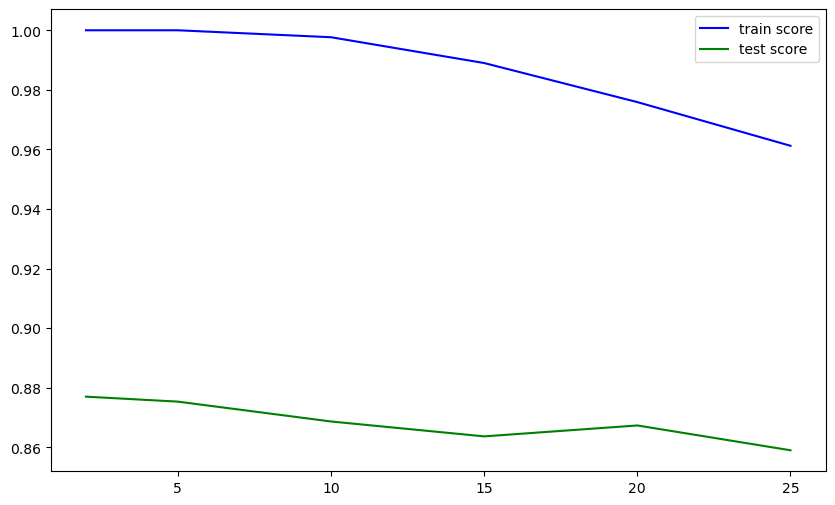

In [29]:
_=plot_scores_by_parameter(extra_constructor,[2,5,10,15,20,25],X_train,X_valid,y_train,y_valid)

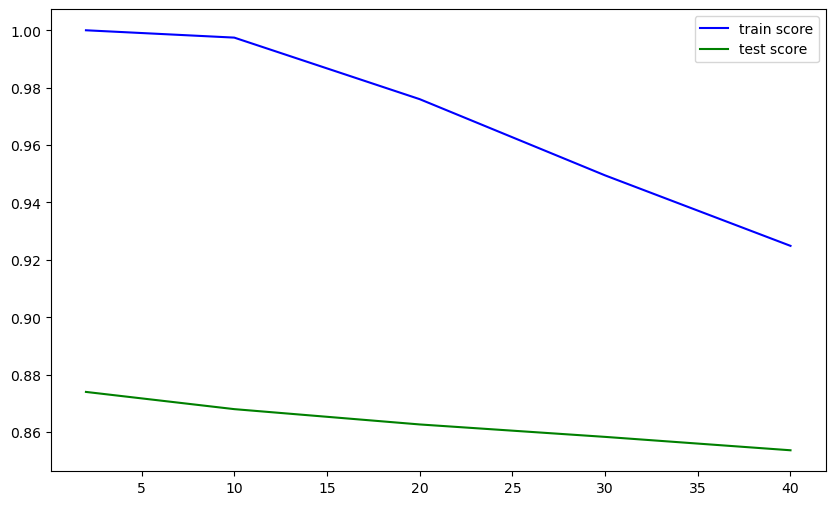

In [30]:
_=plot_scores_by_parameter(extra_constructor,[2,10,20,30,40],X_train,X_valid,y_train,y_valid)

In [31]:
extra_constructor = lambda a: ExtraTreesClassifier(n_estimators = a) 

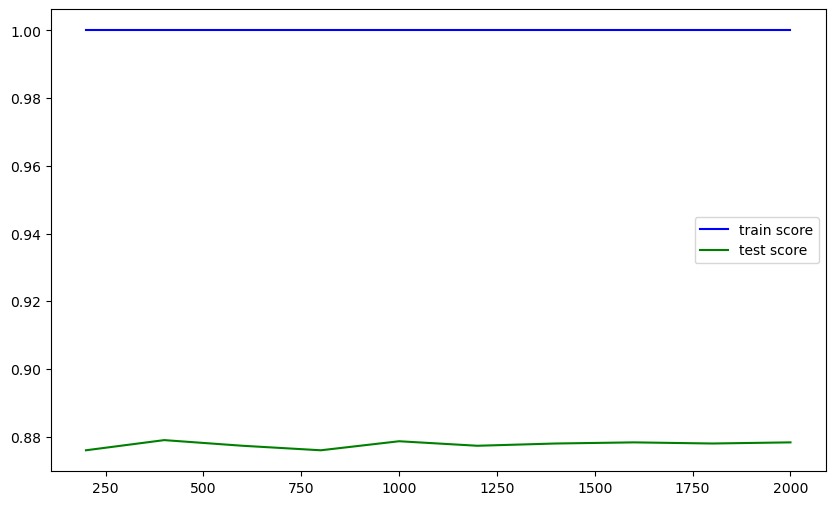

In [33]:
_=plot_scores_by_parameter(extra_constructor,[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],X_train,X_valid,y_train,y_valid)

Тук също има малка вариация при промяна на параметрите и тя пак се дължи на случайността.

In [6]:
from sklearn.metrics import classification_report,accuracy_score,f1_score

In [10]:
random = RandomForestClassifier(bootstrap = True, max_depth = 20)
extra = ExtraTreesClassifier(bootstrap = False, max_features = 'sqrt', max_depth = 20)

random.fit(train_x,train_y)
extra.fit(train_x,train_y)

random_pred = random.predict(test_x)
extra_pred = extra.predict(test_x)

print (f'Random Forest F1 score = {f1_score(test_y, random_pred,average="micro")*100}')
print (f'Extra Trees F1 score = {f1_score(test_y, extra_pred,average="micro")*100}')

print (f'Random Forest Classification Report \n {classification_report(test_y, random_pred, labels=range(0,10))}')
print (f'Extra Trees Classification Report \n {classification_report(test_y, extra_pred, labels=range(0,10))}')

Random Forest F1 score = 85.21
Extra Trees F1 score = 85.36
Random Forest Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.99      0.95      0.97      1000
           2       0.71      0.79      0.75      1000
           3       0.85      0.90      0.87      1000
           4       0.73      0.81      0.77      1000
           5       0.95      0.94      0.95      1000
           6       0.70      0.49      0.58      1000
           7       0.92      0.91      0.91      1000
           8       0.94      0.97      0.95      1000
           9       0.92      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Extra Trees Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.84      0.82      100

В крайна сметка резултатите са почти еднакви, за това нека да разгледаме алоритмите кои пиксели са избрали за най-значителни.

In [20]:
import matplotlib.pyplot as plt

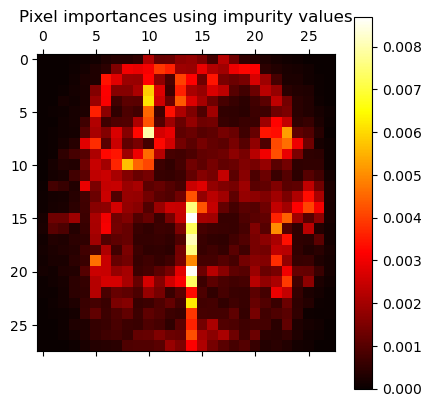

In [19]:
img_shape = (784,1)
importances = random.feature_importances_

imp_reshaped = importances.reshape(img_shape)
imp_reshaped2 = imp_reshaped.reshape(28,28)
plt.matshow(imp_reshaped2, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.show()

Забелязват се много пиксели, които не предоставят никаква информация. В бъдеще би могло да се намали размерността на характеристиките без да наруши резултатът.

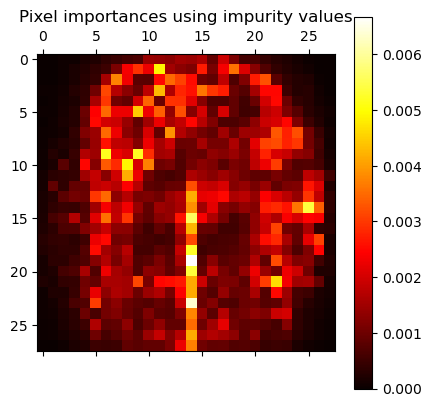

In [21]:
img_shape = (784,1)
importances = extra.feature_importances_

imp_reshaped = importances.reshape(img_shape)
imp_reshaped2 = imp_reshaped.reshape(28,28)
plt.matshow(imp_reshaped2, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.show()

### Decision tree

Нека видим дали може да подобрим DecisionTreeClassifier.

In [1]:
tree_constructor = lambda a: DecisionTreeClassifier(criterion = a) 

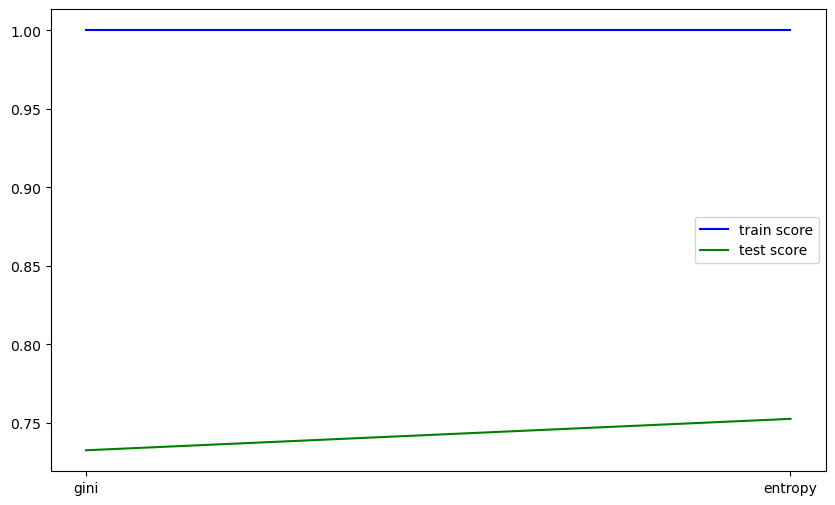

In [14]:
_=plot_scores_by_parameter(tree_constructor,["gini", "entropy"],X_train,X_valid,y_train,y_valid)

Тук може да сме по-сигурни, че построяването на дървото, използвайки ентропията е по-добре, защото липсва елементът на случайността.

In [15]:
tree_constructor = lambda a: DecisionTreeClassifier(criterion = "entropy", max_depth = a) 

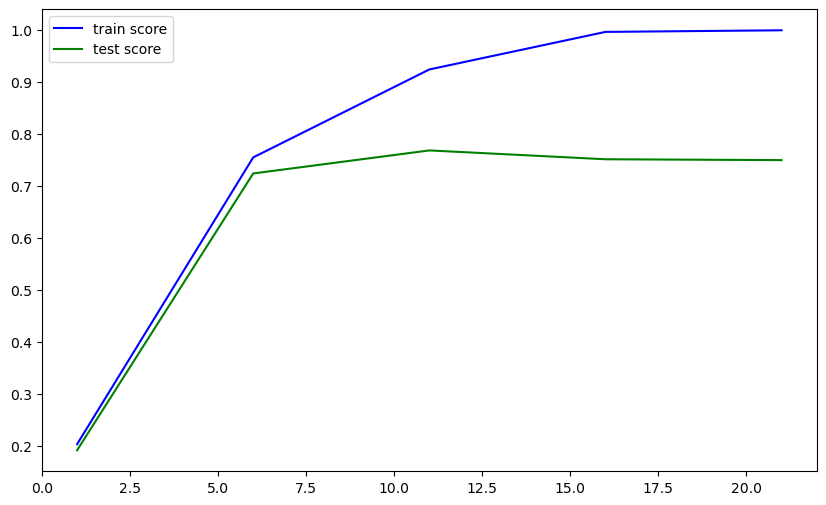

In [18]:
_=plot_scores_by_parameter(tree_constructor,[1,6,11,16,21],X_train,X_valid,y_train,y_valid)

За **max_depth** >= 6 оценката не се променя значително, по при по-големи числа започваме да наблюдаваме overfitting.

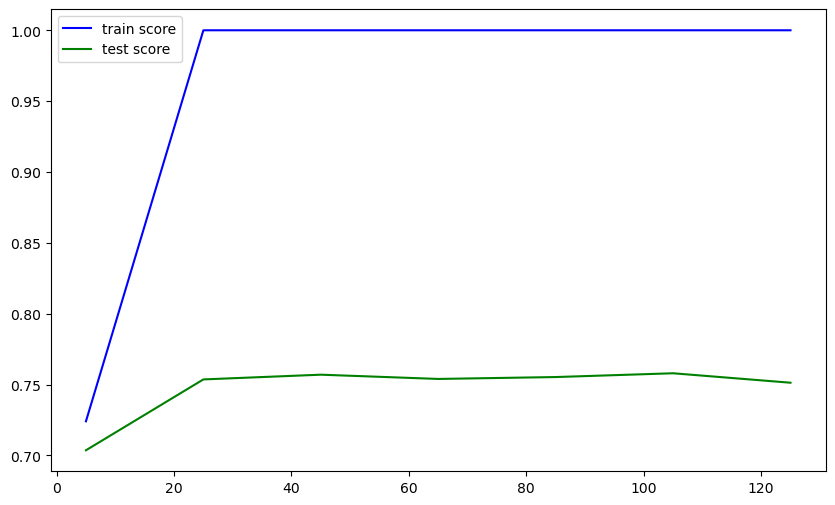

In [19]:
_=plot_scores_by_parameter(tree_constructor,[5,25,45,65,85,105,125,None],X_train,X_valid,y_train,y_valid)

In [20]:
tree_constructor = lambda a: DecisionTreeClassifier(criterion = "entropy", max_depth = None, max_features = a) 

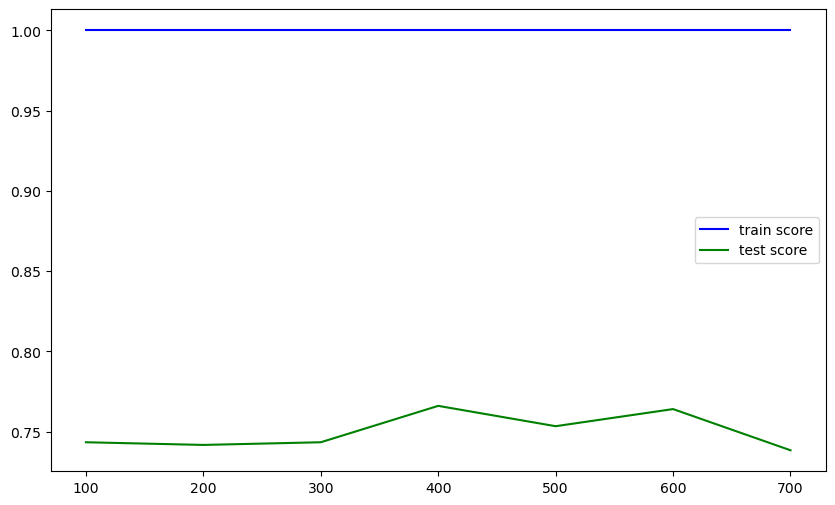

In [24]:
_=plot_scores_by_parameter(tree_constructor,[100,200,300,400,500,600,700],X_train,X_valid,y_train,y_valid)

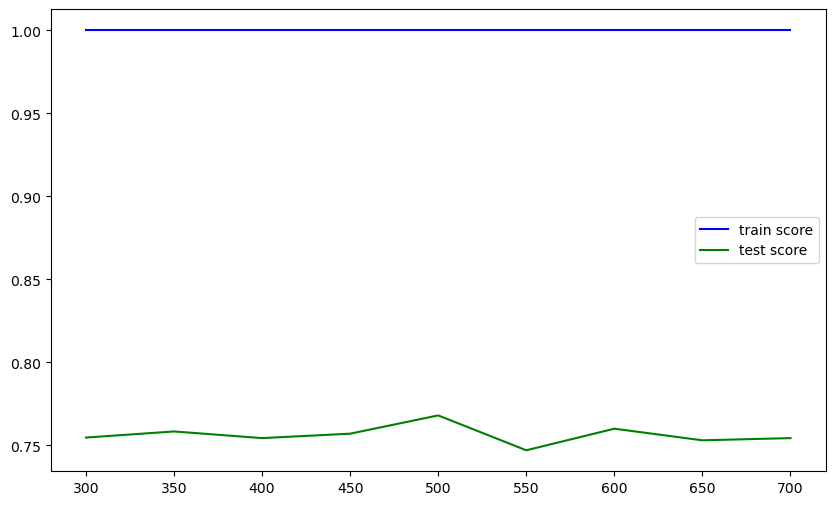

In [26]:
_=plot_scores_by_parameter(tree_constructor,[300,350,400,450,500,550,600,650,700],X_train,X_valid,y_train,y_valid)

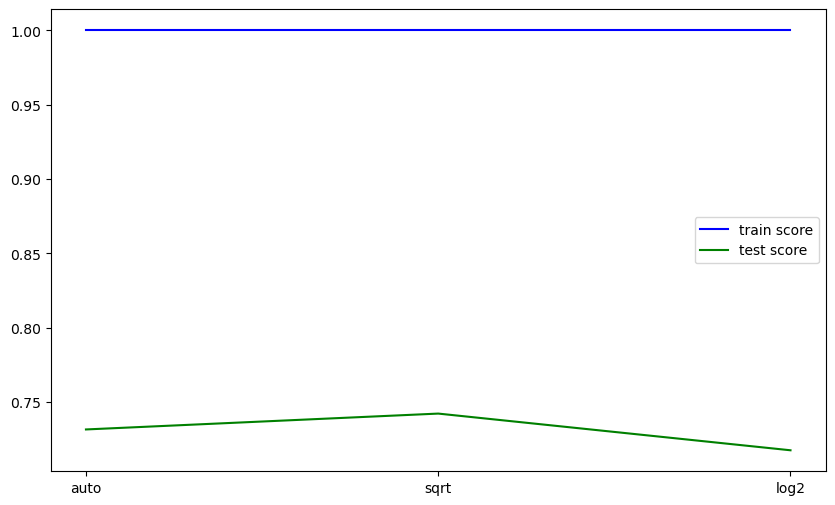

In [25]:
_=plot_scores_by_parameter(tree_constructor,['auto', 'sqrt', 'log2'],X_train,X_valid,y_train,y_valid)

In [27]:
tree_constructor = lambda a: DecisionTreeClassifier(criterion = "entropy", max_depth = None, min_impurity_decrease = a) 

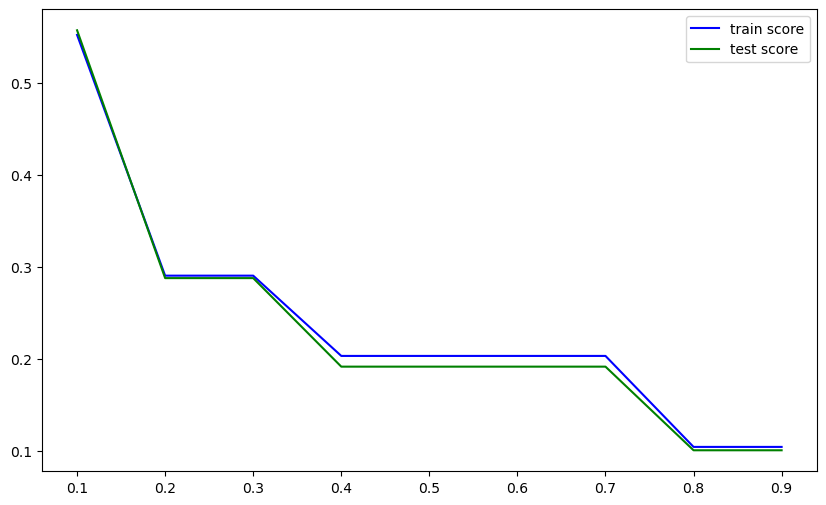

In [28]:
_=plot_scores_by_parameter(tree_constructor,[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],X_train,X_valid,y_train,y_valid)

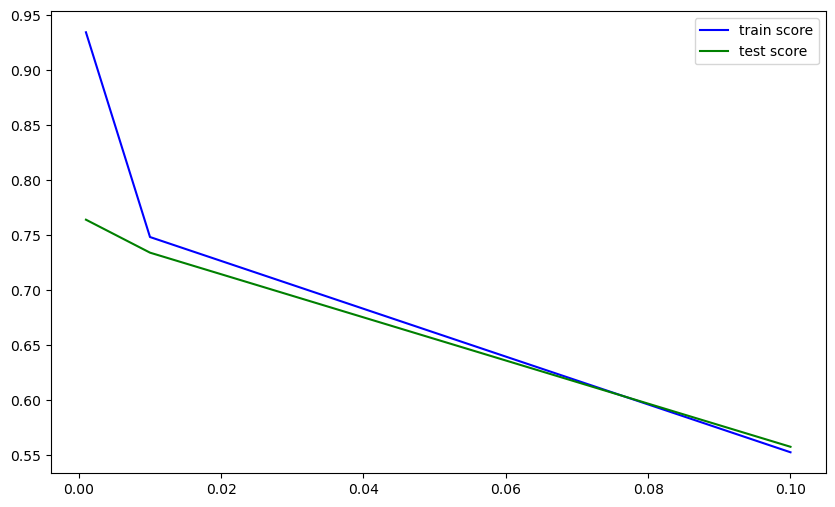

In [29]:
_=plot_scores_by_parameter(tree_constructor,[0.001,0.01,0.1],X_train,X_valid,y_train,y_valid)

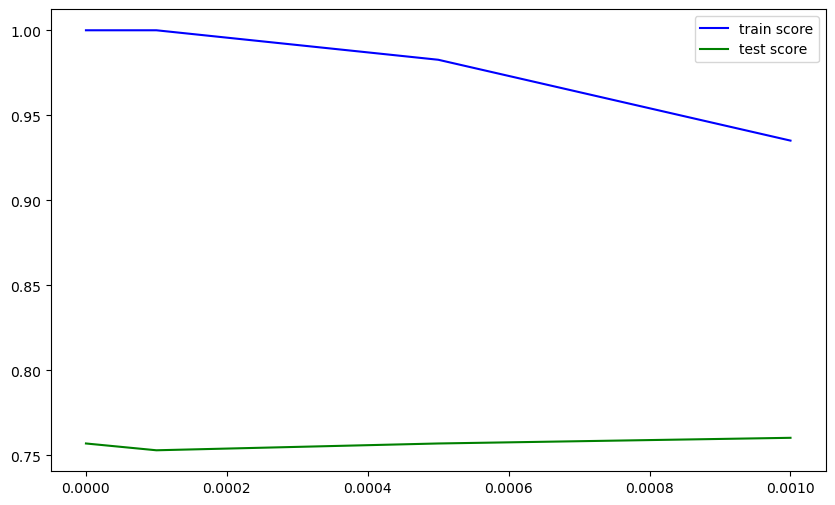

In [30]:
_=plot_scores_by_parameter(tree_constructor,[0.0,0.0001,0.0005,0.001],X_train,X_valid,y_train,y_valid)

In [22]:
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 6) 

tree.fit(train_x,train_y)

tree_pred = tree.predict(test_x)

print (f'Decision Tree F1 score = {f1_score(test_y, tree_pred,average="micro")*100}')

print (f'Decision Tree Classification Report \n {classification_report(test_y, tree_pred, labels=range(0,10))}')

Decision Tree F1 score = 72.72
Decision Tree Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.70      0.74      1000
           1       0.95      0.88      0.91      1000
           2       0.65      0.55      0.60      1000
           3       0.60      0.79      0.68      1000
           4       0.55      0.53      0.54      1000
           5       0.91      0.77      0.84      1000
           6       0.39      0.41      0.40      1000
           7       0.79      0.84      0.81      1000
           8       0.85      0.91      0.88      1000
           9       0.85      0.89      0.87      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



Няма много голяма разлика, за това нека да видим кои пиксели дават най-голяма информация. В случая по-светлите пиксели за са първите избрани.

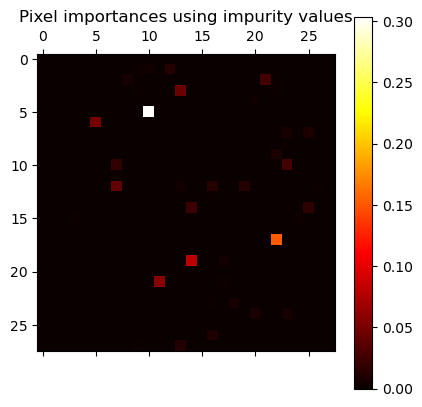

In [23]:
img_shape = (784,1)
importances = tree.feature_importances_

imp_reshaped = importances.reshape(img_shape)
imp_reshaped2 = imp_reshaped.reshape(28,28)
plt.matshow(imp_reshaped2, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.show()